In [1]:
import numpy as np
import torch

In [2]:
import sys
sys.path.append('E:/Projects/XAI/BHEM')
sys.path.append('/run/media/xiangyu/Data/Projects/XAI/BHEM')

from model.explanation.shap_exp import ShapExp
from matplotlib import pyplot as plt
from model import Cnn, getClassifier
from dataset import handwriting
from utils import reconstruct_mask, basic_segment

/home/xiangyu/.conda/envs/PyTc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def delet_top_k_feature(k, img, value):
    total_sum = np.sum(value)

    # Sort the values in descending order and get the corresponding indices
    sorted_indices = np.argsort(-img.flatten())
    sorted_values = value.flatten()[sorted_indices]

    # Calculate the cumulative sum
    cumulative_sum = np.cumsum(sorted_values)

    # Find the index where the cumulative sum exceeds 50% of the total sum
    index = np.argmax(cumulative_sum > k * total_sum)

    # Set the values after the index to 0
    result = img.flatten()
    result[sorted_indices[:index]] = 0
    result = result.reshape(img.shape)

    return result

In [4]:
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn = getClassifier(Cnn, device, f_params='../MINST.pkl')
# %% Load MINST dataset
mnist = handwriting('mnist_784', normalize=True)
testID = 0
Image = torch.from_numpy(mnist.XCnn[testID]).unsqueeze(0)
y = mnist.y[testID]

# Get SHAP Explanation

In [5]:
X_pred = cnn.predict_proba(Image)
y_pred = X_pred.argmax()
X_pred, y_pred

(array([[1.6507509e-09, 5.9369825e-08, 6.6416289e-11, 1.3442679e-02,
         7.8418916e-10, 9.8654050e-01, 7.3488446e-09, 5.5365682e-08,
         1.0980272e-06, 1.5686845e-05]], dtype=float32),
 5)

In [6]:
base_value = X_pred.flatten()[y_pred].item()

In [7]:
basic_seg = basic_segment(Image)
shap_exp = ShapExp(cnn.predict_proba, Image, masker=basic_seg.get_mask())

In [8]:
shap_exp.y_pred, np.argmax(shap_exp.y_pred)

(array([[1.6507509e-09, 5.9369825e-08, 6.6416289e-11, 1.3442679e-02,
         7.8418916e-10, 9.8654050e-01, 7.3488446e-09, 5.5365682e-08,
         1.0980272e-06, 1.5686845e-05]], dtype=float32),
 5)

In [9]:
shap_exp.shap_values.shape

(10, 1, 1, 28, 28)

In [10]:
shap_value_to_analyse = shap_exp.shap_values[y_pred, 0, 0, :, :]
shap_value_to_analyse.shape

(28, 28)

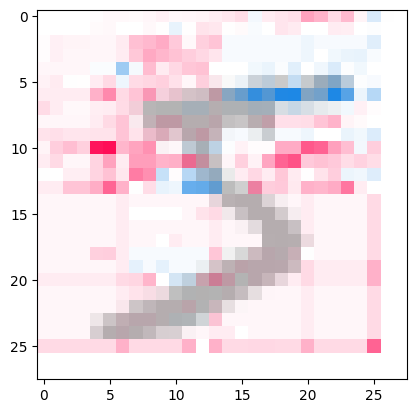

In [11]:
shap_exp.plot_shap()

In [12]:
img_delet_top_k_feature = delet_top_k_feature(0.01, Image.numpy(), shap_value_to_analyse)

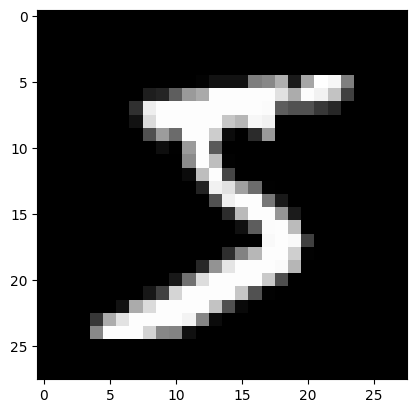

In [13]:
plt.imshow(Image[0,0], cmap='gray')

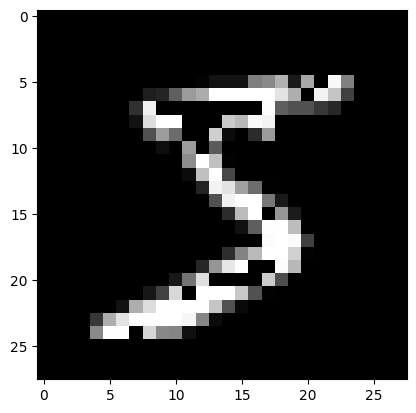

In [14]:
plt.imshow(img_delet_top_k_feature[0,0], cmap='gray')

In [15]:
cnn.predict_proba(img_delet_top_k_feature)

array([[2.2619155e-07, 8.4882531e-06, 3.4615820e-08, 1.4722696e-01,
        3.0162974e-07, 8.5240901e-01, 8.4038749e-07, 5.2870942e-06,
        2.8108925e-05, 3.2082945e-04]], dtype=float32)

In [16]:
# percents = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
percents = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

In [17]:
APOC = [0] * len(percents)

In [18]:
for i in range(len(percents)):
    res = delet_top_k_feature(percents[i], Image.numpy(), shap_value_to_analyse)
    APOC[i] = base_value - cnn.predict_proba(res).flatten()[y_pred]

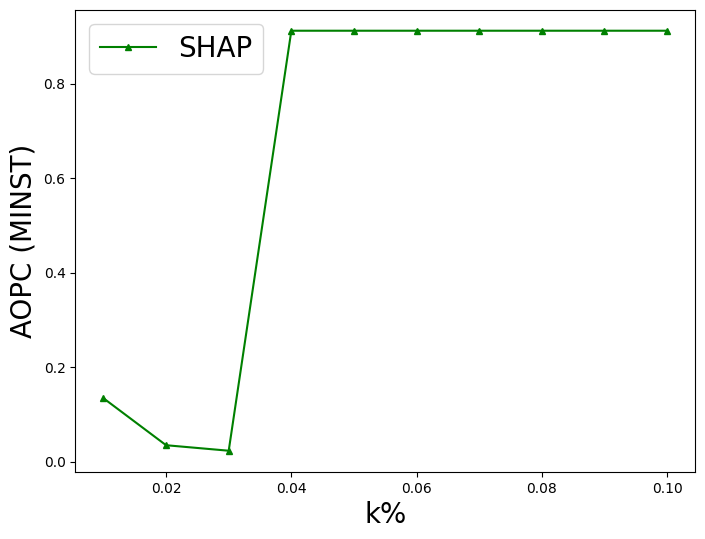

In [19]:
plt.figure(figsize=(8, 6))
# plt.plot(xaxislabel,Bylabel,'s-',markersize = 4,color = 'y',label="BHEM")
plt.plot(percents,APOC,'^-',markersize = 4,color = 'g',label="SHAP")
# plt.plot(xaxislabel,Lylabel,'o-',markersize = 4,color = 'c',label="LIME")
plt.ylabel("AOPC (MINST)",fontsize = 20)
plt.xlabel("k%",fontsize = 20)
# plt.xlim([5,50])
# plt.ylim([0.2,1.0])
plt.legend(prop={'size':20})

# Test on batch image

In [20]:
testnum = 50

In [21]:
percents = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])
APOC = np.array([0.0]*len(percents))

In [22]:
for img_ID in range(testnum):
    Image = torch.from_numpy(mnist.XCnn[img_ID]).unsqueeze(0)
    y = mnist.y[img_ID]

    X_pred = cnn.predict_proba(Image)
    y_pred = X_pred.argmax()
    base_value = X_pred.flatten()[y_pred].item()

    basic_seg = basic_segment(Image)
    shap_exp = ShapExp(cnn.predict_proba, Image, masker=basic_seg.get_mask())

    shap_value_to_analyse = shap_exp.shap_values[y_pred, 0, 0, :, :]

    for i in range(len(percents)):
        res = delet_top_k_feature(percents[i], Image.numpy(), shap_value_to_analyse)
        APOC[i] += base_value - cnn.predict_proba(res).flatten()[y_pred]


In [23]:
APOC/testnum

array([0.08920344, 0.18475403, 0.27618692, 0.39387372, 0.45874261,
       0.53226097, 0.59312296, 0.64609526, 0.68182632, 0.70714105])

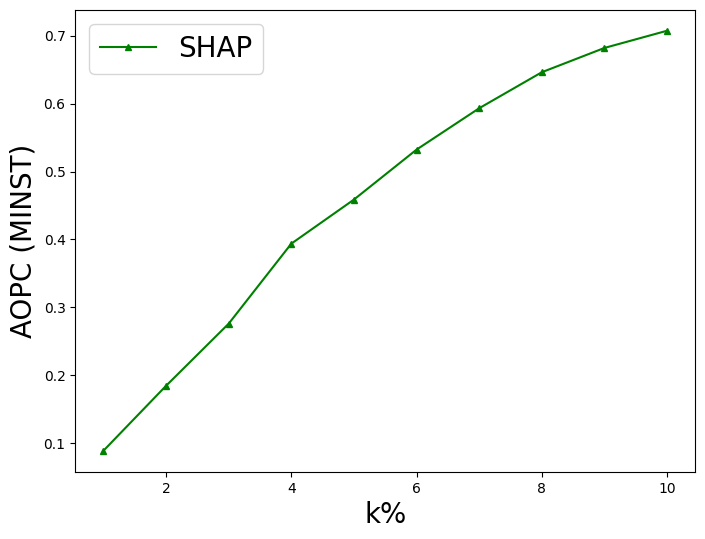

In [24]:
plt.figure(figsize=(8, 6))
# plt.plot(xaxislabel,Bylabel,'s-',markersize = 4,color = 'y',label="BHEM")
plt.plot(percents*100,APOC/testnum,'^-',markersize = 4,color = 'g',label="SHAP")
# plt.plot(xaxislabel,Lylabel,'o-',markersize = 4,color = 'c',label="LIME")
plt.ylabel("AOPC (MINST)",fontsize = 20)
plt.xlabel("k%",fontsize = 20)
# plt.xlim([5,50])
# plt.ylim([0.2,1.0])
plt.legend(prop={'size':20})